In [1]:
import sys
sys.path.insert(0, "../trace/")

import os #checking status of requested files
#os.environ["OMP_NUM_THREADS"] = "24"

import numpy as np #numpy gives us better array management 

#Will be used to create FITS writer 
from astropy.io import fits #astropy modules for FITS IO

import matplotlib  #ploting
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import downscale_local_mean, resize

from tqdm.notebook import trange
from tqdm.notebook import tqdm as tqdm_notebook

import pyfftw
import multiprocessing as mp
#import scipy.signal
import scipy.fft
from matplotlib.colors import LogNorm
ncpu=mp.cpu_count()
pyfftw.config.NUM_THREADS = ncpu

#Trace Library
import tracepol as tp

#Used to monitor progress for multiprocessing pools
def barupdate(result):
    pbar.update()

## How to Compile Fortran libraries
in the utils folder run:  
  
f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'  
  
f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90 --fcompiler=intelem  
  
move the .so files to your library import location (or current directory for your Jupyter notebook)

In [2]:
import spgen as spgen #Python Routines for SpecGen Routines and wrappers for fast-Transit-model.

In [3]:
## Debugging cells

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

## For Debuging
#import importlib

#importlib.reload(spgen) 

## Notebook Parameters  
These parameters set up the work environment and readin model parameters

todo:  
- add rprstype to get planetmodel type

In [4]:
workdir='/data/JWST/' #root folder for local files
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
pmodeltype=2  ## Needs to be added as model parameter.  
trace_file='../trace/NIRISS_GR700_trace.csv'


pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

pars.noversample=1 #example of changing a model parameter

Not found:  rprstype1 9 rprstype 1
Linenumber:  42


## Full Run to get 1-frame  
  
1) Get Instrument Response  
  
todo:  
- responce file should be a parameter

2) Read in Stellar Atmosphere  
  
todo: 
- ~~read in limb-darkening coefficients~~
- read in new Pheonix stellar models 

3) Read in Planet atmosphere 
  
todo:  
- add pmodeltype as model parameter  

4) Set up Trace 
  
todo:  
- set up as a default model parameter

5) Resample Spectra onto a common grid  

todo:  
- ~~common wavelength grid~~
- ~~bin starflux~~
- ~~bin planet r/R*~~
- ~~bin limb-darkening~~
- add interpolation when resolution is insufficient  
  
6) Transit Model  
  
todo:  
- ~~create solin array from pars.sol for each wavelength.~~
- ~~calculate transit-depth at each wavelength~~
- requires integration time
- time should be an array.
- add multiplanet capabilities  
  
7) Reading Kernels
  
todo:  
- resampling of Kernels is not ideal.  Needs thought.
  
8) Generate image with n=1,2,3 orders  
  
todo:
- ~~use resampled star,planet models~~
- ~~use transit model~~  
- scale total flux on detector using ETC output
- add orders -2,-1,0

In [5]:
#1 Instrument response

print('Reading in Response')
response=spgen.readresponse(response_file)

#2 Stellar Atmosphere Model

print('Reading Stellar model')
starmodel_wv,starmodel_flux,ld_coeff=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

#3 Read in Planet atmosphere  

print('Reading in Planet model')
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(workdir+pars.pmodelfile[0],pmodeltype)

#4 Set up Trace 

print('Setting up Trace')
tracePars = tp.get_tracepars(trace_file)

#5 Resample star and planet models to common uniform in wavelength grid.

print('Resampling star and planet model')
#Get wavelength spacing to use for resampling
dw,dwflag=spgen.get_dw(starmodel_wv,planetmodel_wv,pars,tracePars)
print("Wavelength spacing (A): ", dw,dwflag)
#Resample onto common grid.
bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs=\
        spgen.resample_models(dw,starmodel_wv,starmodel_flux,ld_coeff,\
        planetmodel_wv,planetmodel_rprs,pars,tracePars)

#6 Transit model

print('Setting up Transit Model Parameters')
#This will become a routine
#Setup static Solution parameters (LD,r/R* and TED are wavelength dependent)
#This is a single planet example
solin=np.zeros(8+10*pars.nplanet) #TF5 style transit solution array
time=0.0    #time
itime=0.0001 #integration time (days)
solin[0]=np.copy(pars.sol[0]) #Mean stellar density
solin[8]=np.copy(pars.sol[1]) #EPO
solin[9]=np.copy(pars.sol[2]) #Period
solin[10]=np.copy(pars.sol[3]) #Impact parameter
solin[12]=np.copy(pars.sol[4]) #ECW
solin[13]=np.copy(pars.sol[5]) #ESW
solin[14]=np.copy(pars.sol[6]) #KRV
solin[16]=np.copy(pars.sol[7]) #ELL
solin[17]=np.copy(pars.sol[8]) #ALB 

#7 #Read in Kernels

print('Reading in and resampling PSF Kernel')
kernels,kernels_wv=spgen.readkernels(workdir)
#resize Kernels 
#limit oversampling to be: 1<10
kernel_resize=[]
for k in kernels:
    kernel_resize.append(resize(k,(128*pars.noversample,128*pars.noversample)))

Reading in Response
Reading Stellar model
Reading in Planet model
Setting up Trace
Resampling star and planet model


../trace/tracepol.py:86: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


Wavelength spacing (A):  0.9599941999986186 0
Setting up Transit Model Parameters
Reading in and resampling PSF Kernel


## Create Convolved Image

In [6]:
xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample
convolved_image=np.zeros((ymax,xmax))
for norder in range(1,4): #Order to use. (will loop..)

    print('norder',norder)

    pixels=spgen.gen_unconv_image(pars,response,bin_starmodel_wv,bin_starmodel_flux,\
                bin_ld_coeff,bin_planetmodel_rprs,time,itime,solin,norder,tracePars)

    pixels_t=np.copy(pixels.T)

    #Enable threads (not working?!?!)
    #pyfftw.config.NUM_THREADS = 1 #do not need multi-cpu for pools
    #with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
    # Turn on the cache for optimum performance
    #pyfftw.interfaces.cache.enable()

    #do the convolution
    x=pixels_t*0+1.0e-10

    nwv=len(kernels_wv) #number of wavelengths to process
    pbar = tqdm_notebook(total=nwv)  #Will make a progressbar to monitor processing.  
    pool = mp.Pool(processes=ncpu)  #Use lots of threads - because we can! 

    results = [pool.apply_async(spgen.convolve_1wv,\
                            args=(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,norder,tracePars,),\
                            callback=barupdate) for wv_idx in range(nwv)]

    pixels_c = [p.get() for p in results]

    pool.close()
    pool.join()

    #bring together the results
    x=pixels_t*0+1.0e-10
    for p in pixels_c:
        x+=p

    pixels_c=None #release Memory

    convolved_image+=x

norder 1


norder 2


norder 3


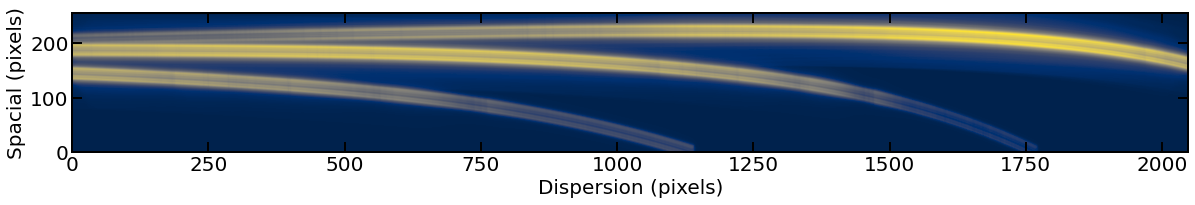

In [7]:
#Plot noise-less image

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

test=np.copy(convolved_image)+10 #adding 10 to make plot prettier. 

cmap = plt.get_cmap('cividis')
ax.imshow(test,norm=LogNorm(),cmap=cmap)
ax.axis((0,test.shape[1],0,test.shape[0]))

ax.set_xlabel('Dispersion (pixels)')
ax.set_ylabel('Spacial (pixels)')

plt.show()

## Lots of Plots

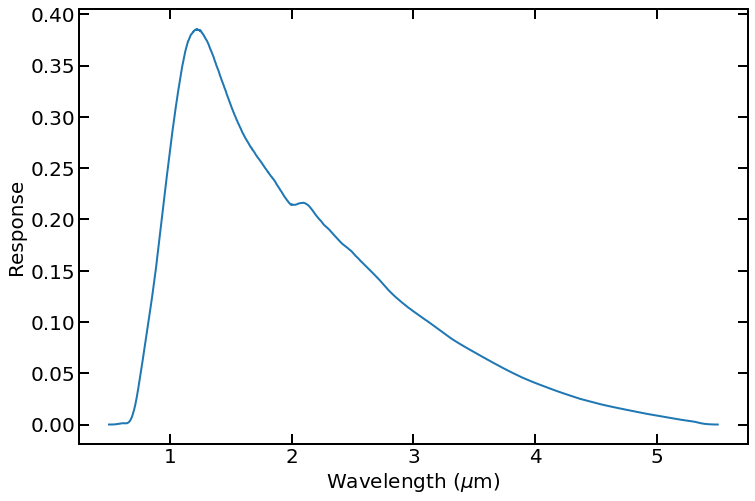

In [8]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(response.wv/10000,response.response[1],lw=2)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Response')

plt.show()

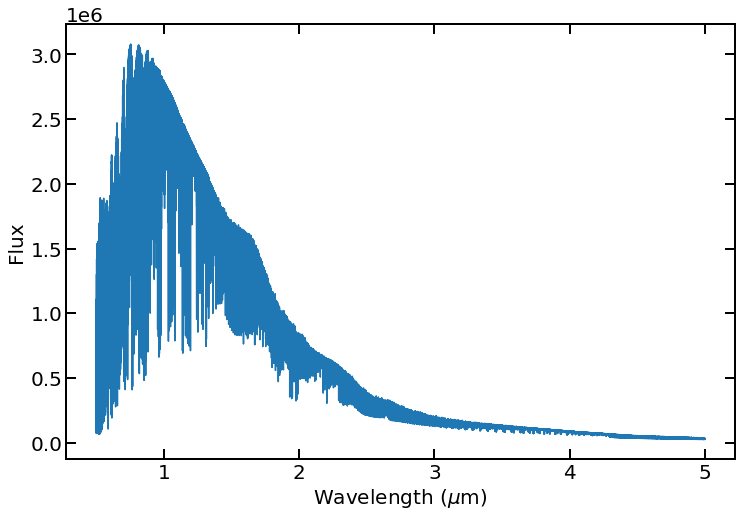

In [9]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(starmodel_wv/10000,starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

plt.show()

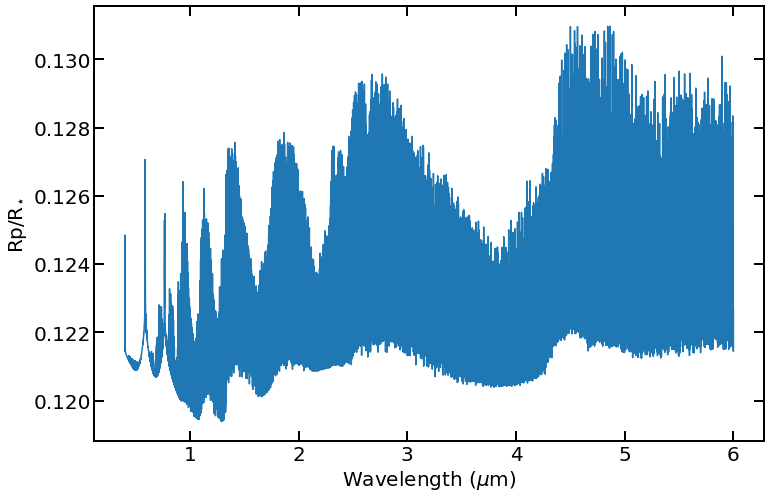

In [10]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(planetmodel_wv/10000,planetmodel_rprs)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

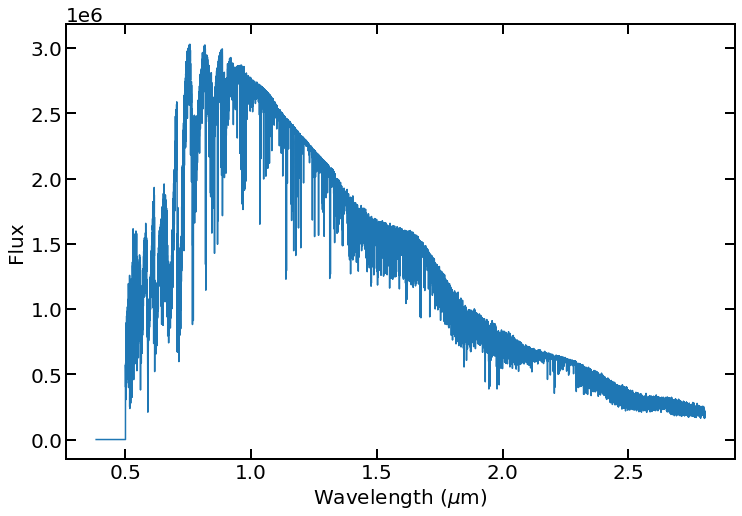

In [11]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_starmodel_wv/10000,bin_starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

plt.show()

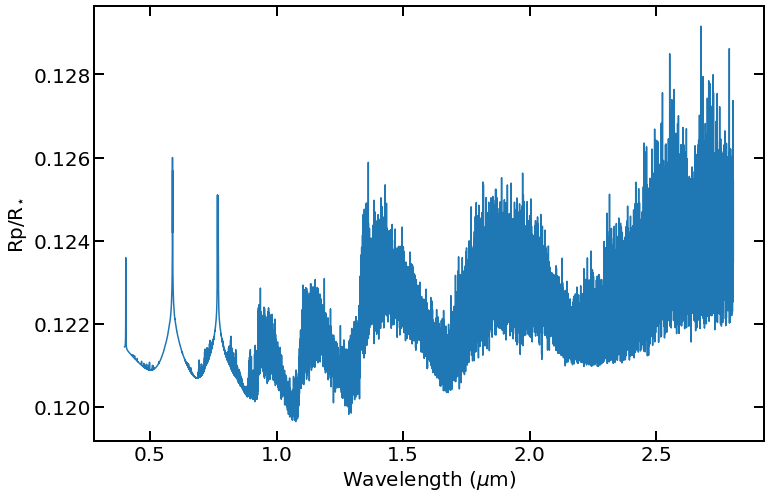

In [15]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_planetmodel_wv[bin_planetmodel_rprs>0]/10000,bin_planetmodel_rprs[bin_planetmodel_rprs>0])

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

In [13]:
##Single Thread example
##Set up FFTW
#pixels_t=np.copy(pixels.T)
#a = pyfftw.empty_aligned((pixels_t.shape[0], pixels_t.shape[1]), dtype='float64')
#b = pyfftw.empty_aligned((kernel_resize[0].shape[0], kernel_resize[0].shape[1]), dtype='float64')
#
##Enable threads (not working?!?!)
#pyfftw.config.NUM_THREADS = ncpu
#
#with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
#    # Turn on the cache for optimum performance
#    pyfftw.interfaces.cache.enable()
#
#    #do the convolution
#    x=cpixels*0+1.0e-10
#    a[:,:] = pixels_t
#    #wv_idx=0 #wavelength choice #Wavelength
#    for wv_idx in trange(len(kernels_wv)):
#        
#        b[:,:] = kernel_resize[wv_idx]
#        x1=scipy.signal.fftconvolve(a, b, mode='same')
#        wl=kernels_wv[wv_idx]
#        dwl=0.05
#        for i in range(x1.shape[1]):
#            wlp=spgen.p2w(i,pars.noversample,norder)/10000.0
#            fac=max(0.0,1.0-np.abs(wlp-wl)/dwl)
#            x1[:,i]=x1[:,i]*fac
#        
#        #x1=convolve_1wv(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,norder)
#        
#        x+=x1